## Homework 9

Felipe Alves - N14713445

Risk neutral asset pricing formula
    $$ p_t = \beta \mathbb{E}_t [ d_{t+1} + p_{t+1} ] $$
In particular, assume that 
    $$ d_t = x_t' D x_t $$
where the state process $x_t$ evolves according to 
    $$ x_{t+1} = A x_t + C w_{t+1} $$

Let's conjecture that $p_t = p(x_t)$ for some function $p$. In particular, we will guess that 
$p(x) = x'Px + \delta$ for some positive definite $P$ and scalar $\delta$.

Verifying our guess yields the following solution
\begin{align*}
    P^* & = \beta A' P^* A + \beta A' D A \\
    \delta^* & = \frac{ \beta }{ 1-\beta } \text{trace}(C'(D+P^*)C)
\end{align*}


In [1]:
using QuantEcon

In [2]:
"""
A type to compute asset prices from risk neutral asset pricing

    p_t + β E_t [ d_{t+1}+ p_{t+1} ]

with 

    d_t = x_t ' D x_t

where {x_t} evolution is given by

x_t+1 = A x_t + C w_t+1, w_t∼N(0,1)
    
##### Fields

- `β::Float64`          : Discount factor in (0, 1)
- `A::Matrix{Float64}`  : 
- `C::Matrix{Float64}`  : 
- `D::Matrix{Float64}`  : 
"""
type AssetPrices
    β::Float64
    A::Matrix{Float64}
    C::Matrix{Float64}
    D::Matrix{Float64}
    
    Pstar::Matrix{Float64}
    δstar::Float64
end

function AssetPrices(β::Float64, A::Matrix{Float64}, C::Matrix{Float64}, D::Matrix{Float64})
    
    AssetPrices(β, A, C, D, zeros(A),0.)
end

AssetPrices

In [3]:
function lyapunov_ope(X::Matrix{Float64},A::Matrix{Float64},M::Matrix{Float64})
    return A' * X * A + M
end

"""
Computes the pricing formula by iterating on Lyapunov operator
"""
function stationary_values!(ap::AssetPrices)
    
    #= Unpack values =#
    β = ap.β
    A = ap.A
    C = ap.C
    D = ap.D

    #== check stability condition ==#
    all(abs(eigvals(A)) .< 1/sqrt(β)) == false && throw(ArgumentError("Matrix A does not satisfy stability conditions"))

    #== Put in notation for Lyapunov operator ==#     
    Λ = β^.5 * A
    M = β * A' * D * A

    #= Compute the fixed point =#
    P0 = zeros(A)    
    lyap_ope(P) = lyapunov_ope(P, Λ, M) 
    
    ap.Pstar = compute_fixed_point(lyap_ope, P0, err_tol=1e-5)
    ap.δstar = (1-β)\β * trace(C'*(D + ap.Pstar)*C)
    
    return Void 
end

"""
Computes the pricing formula by using solve_discrete_lyapunov 
routine from QuantEcon
"""
function stationary_values2!(ap::AssetPrices)
    
    #= Unpack values =#
    β = ap.β
    A = ap.A
    C = ap.C
    D = ap.D
    
    #== check stability condition ==#
    all(abs(eigvals(A)) .< 1/sqrt(β)) == false && throw(ArgumentError("Matrix A does not satisfy stability conditions"))
    
    #== Put in notation for Lyapunov operator ==#     
    Λ = β^.5 * A
    M = β * A' * D * A

    #= Compute the fixed point =#
    P0 = zeros(A)    

    ap.Pstar = solve_discrete_lyapunov(Λ, M)
    ap.δstar = (1-β)\β * trace(C'*(D + ap.Pstar)*C)
    
    return Void 
end

function compute_p(X::Vector{Vector{Float64}}, ap::AssetPrices)
    Pstar, δstar = ap.Pstar, ap.δstar
    Float64[dot(X[i],Pstar *X[i]) + δstar for i in 1:length(X)]
end

compute_p (generic function with 1 method)

In [4]:
β = 0.9
A = [1.8 -0.1; -0.1 0.8]
C = eye(2)
D = eye(2)

#= Test error message =#
ap  = AssetPrices(β, A, C, D)
stationary_values!(ap)

LoadError: LoadError: ArgumentError: Matrix A does not satisfy stability conditions
while loading In[4], in expression starting on line 8

In [5]:
β = 0.9
A = [0.8 -0.1; -0.1 0.8]
C = eye(2)
D = eye(2)

#= Test error message =#
ap  = AssetPrices(β, A, C, D)
ap2  = AssetPrices(β, A, C, D)

AssetPrices(0.9,2x2 Array{Float64,2}:
  0.8  -0.1
 -0.1   0.8,2x2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0,2x2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0,2x2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0,0.0)

Timing the two versions of the code

In [12]:
@time stationary_values!(ap)

Compute iterate 10 with error 0.021334688352331987

Void


Compute iterate 20 with error 0.000898543852704492
Compute iterate 30 with error 3.808868479060479e-5
Converged in 35 steps
  0.001167 seconds (787 allocations: 47.922 KB)


In [13]:
@time stationary_values2!(ap2)

Void

 0.000086 seconds (175 allocations: 15.141 KB)


In [14]:
## Comparting the results
@printf("Pstar = [%.3f, %.3f]\n", ap.Pstar[1,1], ap.Pstar[1,2])
@printf("        [%.3f, %.3f]\n", ap.Pstar[2,1], ap.Pstar[2,2])

print("\n")
@printf("Pstar = [%.3f, %.3f]\n", ap2.Pstar[1,1], ap2.Pstar[1,2])
@printf("        [%.3f, %.3f]\n", ap2.Pstar[2,1], ap2.Pstar[2,2])



Pstar = [1.739, -0.951]
        [-0.951, 1.739]

Pstar = [1.739, -0.951]
        [-0.951, 1.739]


### Plot

In [9]:
# Quick meshgrid function
meshgrid(x::Vector, y::Vector) = (repmat(x, 1, length(y))',
                                  repmat(y, 1, length(x)))
n1 = 50
n2 = 50
x1_grid = collect(linspace(-10., 10., n1))
x2_grid = collect(linspace(-10., 10., n2))
X, Y = meshgrid(x1_grid, x2_grid)

xmatr = [X[:] Y[:]]'


2x2500 Array{Float64,2}:
 -10.0  -10.0      -10.0      …  10.0      10.0      10.0      10.0
 -10.0   -9.59184   -9.18367      8.77551   9.18367   9.59184  10.0

In [10]:
x = Vector{Float64}[xmatr[:,i] for i=1:size(xmatr,2)]

Z = compute_p(x, ap)
Z = reshape(Z,n2,n1)

1.739, -0.951]
        [-0.951, 1.739]

Pstar = [1.739, -0.951]
        [-0.951, 1.739]


50x50 Array{Float64,2}:
 207.092  200.942  195.371  190.38   …  524.04   544.55   565.64   587.309
 200.942  194.475  188.587  183.279     503.321  523.514  544.287  565.64 
 195.371  188.587  182.383  176.758     483.181  503.058  523.514  544.55 
 190.38   183.279  176.758  170.817     463.621  483.181  503.321  524.04 
 185.968  178.551  171.713  165.455     444.64   463.884  483.707  504.109
 182.136  174.402  167.248  160.673  …  426.239  445.166  464.672  484.758
 178.884  170.833  163.362  156.471     408.418  427.028  446.218  465.987
 176.211  167.844  160.056  152.848     391.176  409.47   428.342  447.795
 174.118  165.434  157.329  149.804     374.514  392.491  411.047  430.182
 172.604  163.603  155.182  147.341     358.432  376.091  394.331  413.15 
 171.67   162.353  153.615  145.456  …  342.929  360.272  378.194  396.696
 171.315  161.681  152.627  144.152     328.005  345.031  362.637  380.823
 171.54   161.59   152.218  143.427     313.661  330.371  347.66   365.529
 

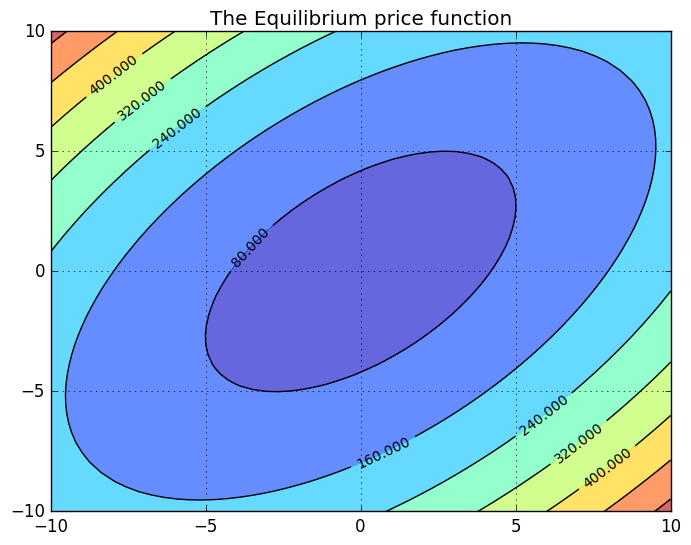

PyObject <matplotlib.text.Text object at 0x0000000029315208>

In [11]:
using PyPlot

#= Create Countor Plot =#
fig, ax = subplots()
ax[:xaxis][:grid](true, zorder=0)
ax[:yaxis][:grid](true, zorder=0)
ax[:contourf](X, Y, Z, 8, alpha=0.6, cmap=ColorMap("jet"))
cs = ax[:contour](X, Y, Z, 8, colors="black")
ax[:clabel](cs, inline=1, fontsize=10)
ax[:set_title]("The Equilibrium price function")
